# Setting up Paths

In [1]:
#path to the data
pathCOMPASOutput = '/Volumes/Virgo/DATA/BHNS/Fiducial/'
#path to compasrepo which contains ther popsynth folder
# pathRepo = '/Users/floorbroekgaarden/Programs/COMPAS/popsynth/Papers/BroekgaardenEtAl/black_hole-neutron_star/Scripts'



pathPostProcessing = '/Users/floorbroekgaarden/Projects/BHNS_project/Scripts'




# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import time
import sys
import copy
#Quick fudge to make import from ../Scripts work
import sys
sys.path.append('/Users/floorbroekgaarden/Projects/BHNS_project/Scripts')
# sys.path.append(pathPostProcessing+'/2_CosmicIntegration')

# Custom Imports from COMPASrepo

In [3]:
import ClassCosmicIntegrator  as CI #Given settings and redshifts returns rates (2D arrays) Loads the data
# import ClassEvents            as CE
# import ClassBayes             as CB
import coencodeVarious        as CV
from PostProcessingScripts import * 


ImportError: No module named ClassCosmicIntegrator

# The cosmic integrator class

In [1]:
#Will only look at BBHs so might as well set everything
minz = 0.
maxz = 2.
resz = 1000
Data = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes='BHNS',\
       minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=False, Cosmology='WMAP', COMPASbinaryFraction=0.6)

#I use the custom cosmology because this was the flatlambda prescription used before WMAP Stevenson et al 2019
#Doesnt matter to much (between WMAP and 
#this it is 22, and 22.7 per year) but to prevent redoing all the numbers in the tex for referee

print(Data.COMPAS.mass1)

NameError: name 'CI' is not defined

# The plot

In [ ]:
#The distribution of DCOs as a function of redshift

method     = ['logNormal'                ,'MZ_GSMF'                     ,'MZ_GSMF'                      , 'MZ_GSMF']
SFRs       = ['Neijssel et al. (2019)'   ,'Madau et al. (2014)'         ,'Madau et al. (2014)'          , 'Madau et al. (2014)']
logNormal  = ['Neijssel Phenomenological', None                         , None                          , None]
GSMFs      = [None                       , 'Panter et al. (2004) Single', 'Furlong et al. (2015) Single', 'Panter et al. (2004) Single']
MZs        = [None                       , 'Langer et al. (2006)'       , 'Langer et al. (2006)'        , 'Ma et al. (2015)']

linestyles = ['-'                        , '--'                         , ':'                           , '-.']
labels     = ['Preferred model'          , 'Barrett et al. (2018) MSSFR', 'Furlong et al. (2015) Single', 'Ma et al. (2015)']


cm       = plt.get_cmap('viridis')
nColors  = 3+1  #want three colours for three variations (1 used in other plot later)
                    # dont want the brigthest colour hence I add a dummy value.
                    #Should be consistent with figure of metallicity PDFs
mycolors = [cm(x) for x in np.linspace(0,1 , nColors)]

colours  =  [ 'k'                        ,mycolors[0]                   , mycolors[1]                   , mycolors[2]]




rates    = []
totals   = []
for nrL, L in enumerate(labels):
    Data.MSSFR.Zprescription         = method[nrL]
    Data.MSSFR.SFRprescription       = SFRs[nrL]
    Data.MSSFR.logNormalPrescription = logNormal[nrL]
    Data.MSSFR.GSMFprescription      = GSMFs[nrL]
    Data.MSSFR.ZMprescription        = MZs[nrL]
    Data.cosmologicalIntegration()
        
    
    Row        =np.sum(Data.PerSystemPerRedshift_ratesObserved, axis=0)
    rates.append(Row)
    totals.extend([np.sum(Row)])
    print(L, np.sum(Row))

In [ ]:
##### For each observation (column) we draw a chirpmass with probability gaussian

events     = CE.Observations() 
names, values, lowerErrors, upperErrors, survey =\
events.giveParameterAndError(parameter='Mchirp', types=['BBH'])  


draws = 5000
arraydraws = np.zeros(shape=(draws, len(names)))


Mtot       = Data.COMPAS.mChirp
bins       = np.linspace(0,60,250)
centerx     = (bins[1:]+bins[:-1])/2.
dMtot      = np.diff(bins)
gaussians  = []

Bayes      = CB.BayesianLikelyhoodSingleObservation(datapoints = Data.COMPAS.mChirp)
for nre, event in enumerate(names):
    Bayes.setObservation(observation=values[nre], lowerError=lowerErrors[nre], \
                         upperError=upperErrors[nre], confidence=0.9)
    Bayes.calculatePDFposterior()
    pdf, bins = np.histogram(Bayes._x, bins=bins, weights=Bayes._PDFobservation)
    gaussians.append(pdf)
    
    sigma   = Bayes._sigmaSymmetric
    mu      = Bayes._symmetricMu
    s = np.random.normal(mu, sigma, draws)
    arraydraws[:,nre] = s

In [ ]:
###### Turn each PDF into CDF per model

chirpMasses     = Data.COMPAS.mChirp
indexSortMasses = np.argsort(chirpMasses)
sortedMasses    = chirpMasses[indexSortMasses]
CDFs            = []
for nrM, model in enumerate(labels):
    sortedRate  = rates[nrM][indexSortMasses]
    CDFs.append(np.cumsum(sortedRate)/float(np.sum(sortedRate)))
fig, axes = plt.subplots(1,1)
for cdf in CDFs:
    axes.plot(sortedMasses, cdf)
plt.show()

In [ ]:
def return10Masses(cdf, masses):
    #draw number between 0-1
    nrdraws = 10
    d = np.random.uniform(low=0.0, high=1.0, size=nrdraws)
    #find nearest value cdf
    indices = np.zeros(nrdraws, dtype=int)
    for nrd, draw in enumerate(d):
        difference   = np.abs(cdf-draw)
        minimum      = np.min(difference)
        indices[nrd] = int(np.where(difference == minimum)[0][0])
    indices = np.array(indices)
    return np.sort(masses[indices])

y10draws = np.cumsum(np.ones(10)/np.sum(np.ones(10)))
x10draws = []
counter  = 0
while counter < draws:
    masses = return10Masses(CDFs[0], sortedMasses)
    x10draws.append(masses)
    counter+=1
    
print(len(x10draws))

In [ ]:
fig        = plt.subplots(1,1,figsize=(9,14))
ax0        = plt.subplot2grid((6,3),(0,0), colspan=3, rowspan=3)
# ax1        = plt.subplot2grid((6,3),(3,0), colspan=3, rowspan=3)

# ax12 = ax1.twinx() #right side bottom panel for cumulative

############
#  Top panel with MSSFR
############
Mtot       = Data.COMPAS.mChirp
bins       = np.linspace(1,7.5,100)
center     = (bins[1:]+bins[:-1])/2.
dMtot      = np.diff(bins)

for nrL, L in enumerate(labels):
    rate       = rates[nrL]
    rate, _    = np.histogram(Mtot, bins=bins, weights = rate)
    rate       = np.divide(rate, dMtot)
    rate       = rate / np.sum(rate)
    label      = labels[nrL]+r' $\rm \normalfont [%s \ yr^{-1}]$' %(int(totals[nrL]))
    ax0.plot(center, rate, lw=3.5, c=colours[nrL], label=label, linestyle=linestyles[nrL], alpha=0.85)
# ax0.get_xaxis().set_visible(True)
nameX = r'$\rm M_{chirp}\ \ [M_{\odot}] $'
nameY = r'$\rm dP / dM_{chirp} \ [M_{\odot}^{-1}]  $'
ax0 = CV.layoutAxes(ax0, nameX=nameX, nameY=nameY)
ax0.legend(loc=1, prop={'size':16})
ax0.set_ylim(bottom=-0.002, top=0.071)


##########
#
#########


    
# ax12.set_xlim(ax0.get_xlim())
# ax1.set_xlim(ax0.get_xlim())
# ax1.set_ylim(top=1.01)
# y = ax1.get_yticks()
# ax1.set_yticks(y[:-2])
# ax12.set_ylim(top=0.8)
# ax12.get_yaxis().set_visible(False)
# nameX = r'$\rm M_{chirp}\ \ [M_{\odot}] $'
# nameY = r'$\rm CDF $'
# ax1 = CV.layoutAxes(ax1, nameX=nameX, nameY=nameY)
# ax12 = CV.layoutAxes(ax12, nameX='', nameY='', second=True)
plt.tight_layout()
# plt.subplots_adjust(wspace=0., hspace=0.0)
plt.savefig('./MassDistributionAtRedshiftObs.png', dpi=300, transparent=False)
plt.show()
# plt.close()

In [ ]:
fig        = plt.subplots(1,1,figsize=(9,14))
ax0        = plt.subplot2grid((6,3),(0,0), colspan=3, rowspan=3)
# ax1        = plt.subplot2grid((6,3),(3,0), colspan=3, rowspan=3)

# ax12 = ax1.twinx() #right side bottom panel for cumulative

############
#  Top panel with MSSFR
############

M1         = Data.COMPAS.mass1
M2         = Data.COMPAS.mass2
MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)
var_x = MBH 

bins       = np.linspace(3,20,100)
center     = (bins[1:]+bins[:-1])/2.
dvar_x      = np.diff(bins)

for nrL, L in enumerate(labels):
    rate       = rates[nrL]
    rate, _    = np.histogram(var_x, bins=bins, weights = rate)
    rate       = np.divide(rate, dvar_x)
    rate       = rate / np.sum(rate)
    label      = labels[nrL]+r' $\rm \normalfont [%s \ yr^{-1}]$' %(int(totals[nrL]))
    ax0.plot(center, rate, lw=3.5, c=colours[nrL], label=label, linestyle=linestyles[nrL], alpha=0.85)
# ax0.get_xaxis().set_visible(True)
nameX = r'$\rm Mass BH\ \ [M_{\odot}] $'
nameY = r'$\rm dP / dM_{BH} \ [M_{\odot}^{-1}]  $'
ax0 = CV.layoutAxes(ax0, nameX=nameX, nameY=nameY)
ax0.legend(loc=1, prop={'size':16})
ax0.set_ylim(bottom=-0.002, top=0.071)


##########
#
#########


    
# ax12.set_xlim(ax0.get_xlim())
# ax1.set_xlim(ax0.get_xlim())
# ax1.set_ylim(top=1.01)
# y = ax1.get_yticks()
# ax1.set_yticks(y[:-2])
# ax12.set_ylim(top=0.8)
# ax12.get_yaxis().set_visible(False)
# nameX = r'$\rm M_{chirp}\ \ [M_{\odot}] $'
# nameY = r'$\rm CDF $'
# ax1 = CV.layoutAxes(ax1, nameX=nameX, nameY=nameY)
# ax12 = CV.layoutAxes(ax12, nameX='', nameY='', second=True)
plt.tight_layout()
# plt.subplots_adjust(wspace=0., hspace=0.0)
plt.savefig('./MassBHDistributionAtRedshiftObs.png', dpi=300, transparent=False)
plt.show()
# plt.close()

In [ ]:
fig        = plt.subplots(1,1,figsize=(9,14))
ax0        = plt.subplot2grid((6,3),(0,0), colspan=3, rowspan=3)
# ax1        = plt.subplot2grid((6,3),(3,0), colspan=3, rowspan=3)

# ax12 = ax1.twinx() #right side bottom panel for cumulative

############
#  Top panel with MSSFR
############

M1         = Data.COMPAS.mass1
M2         = Data.COMPAS.mass2
MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)
var_x = MNS 

bins       = np.linspace(1,3,100)
center     = (bins[1:]+bins[:-1])/2.
dvar_x      = np.diff(bins)

for nrL, L in enumerate(labels):
    rate       = rates[nrL]
    rate, _    = np.histogram(var_x, bins=bins, weights = rate)
    rate       = np.divide(rate, dvar_x)
    rate       = rate / np.sum(rate)
    label      = labels[nrL]+r' $\rm \normalfont [%s \ yr^{-1}]$' %(int(totals[nrL]))
    ax0.plot(center, rate, lw=3.5, c=colours[nrL], label=label, linestyle=linestyles[nrL], alpha=0.85)
# ax0.get_xaxis().set_visible(True)
nameX = r'$\rm Mass NS\ \ [M_{\odot}] $'
nameY = r'$\rm dP / dM_{NS} \ [M_{\odot}^{-1}]  $'
ax0 = CV.layoutAxes(ax0, nameX=nameX, nameY=nameY)
ax0.legend(loc=1, prop={'size':16})
ax0.set_ylim(bottom=-0.002, top=0.091)


##########
#
#########


    
# ax12.set_xlim(ax0.get_xlim())
# ax1.set_xlim(ax0.get_xlim())
# ax1.set_ylim(top=1.01)
# y = ax1.get_yticks()
# ax1.set_yticks(y[:-2])
# ax12.set_ylim(top=0.8)
# ax12.get_yaxis().set_visible(False)
# nameX = r'$\rm M_{chirp}\ \ [M_{\odot}] $'
# nameY = r'$\rm CDF $'
# ax1 = CV.layoutAxes(ax1, nameX=nameX, nameY=nameY)
# ax12 = CV.layoutAxes(ax12, nameX='', nameY='', second=True)
plt.tight_layout()
# plt.subplots_adjust(wspace=0., hspace=0.0)
plt.savefig('./MassNSDistributionAtRedshiftObs.png', dpi=300, transparent=False)
plt.show()
# plt.close()

# 1. mass ratio distribution 

In [8]:
#The distribution of DCOs as a function of redshift

method     = ['logNormal'                ,'MZ_GSMF'                     ,'MZ_GSMF'                      , 'MZ_GSMF']
SFRs       = ['Neijssel et al. (2019)'   ,'Madau et al. (2014)'         ,'Madau et al. (2014)'          , 'Madau et al. (2014)']
logNormal  = ['Neijssel Phenomenological', None                         , None                          , None]
GSMFs      = [None                       , 'Panter et al. (2004) Single', 'Furlong et al. (2015) Single', 'Panter et al. (2004) Single']
MZs        = [None                       , 'Langer et al. (2006)'       , 'Langer et al. (2006)'        , 'Ma et al. (2015)']

linestyles = ['-'                        , '--'                         , ':'                           , '-.']
labels     = ['Preferred model'          , 'Barrett et al. (2018) MSSFR', 'Furlong et al. (2015) Single', 'Ma et al. (2015)']


cm       = plt.get_cmap('viridis')
nColors  = 3+1  #want three colours for three variations (1 used in other plot later)
                    # dont want the brigthest colour hence I add a dummy value.
                    #Should be consistent with figure of metallicity PDFs
mycolors = [cm(x) for x in np.linspace(0,1 , nColors)]

colours  =  [ 'k'                        ,mycolors[0]                   , mycolors[1]                   , mycolors[2]]




In [9]:
#path to the data
pathCOMPASOutput = '/Volumes/Virgo/DATA/BHNS/Fiducial/'
modelname = 'Fiducial'
#Will only look at BBHs so might as well set everything
minz = 0.
maxz = 1.
resz = 50
Data_model1 = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes='BHNS',\
       minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=False, Cosmology='Custom Flat')

#I use the custom cosmology because this was the flatlambda prescription used before WMAP Stevenson et al 2019
#Doesnt matter to much (between WMAP and 
#this it is 22, and 22.7 per year) but to prevent redoing all the numbers in the tex for referee

print(Data_model1.COMPAS.mass1)
print(len(Data_model1.COMPAS.mass1))

weighted samples :-D
Remember to  self.setCOMPASDCOmask() adag and self.setCOMPASData()
[2.06203 9.0769  2.98903 ... 4.78319 4.4085  4.66631]
1366530


In [11]:
rates_model1    = []
totals_model1   = []
for nrL, L in enumerate(labels):
    Data_model1.MSSFR.Zprescription         = method[nrL]
    Data_model1.MSSFR.SFRprescription       = SFRs[nrL]
    Data_model1.MSSFR.logNormalPrescription = logNormal[nrL]
    Data_model1.MSSFR.GSMFprescription      = GSMFs[nrL]
    Data_model1.MSSFR.ZMprescription        = MZs[nrL]
    Data_model1.cosmologicalIntegration()
    weightSTROOPWAFEL = Data_model1.COMPAS.weight # //floor weight
    Row        =  np.sum(Data_model1.PerSystemPerRedshift_ratesObserved*weightSTROOPWAFEL, axis=0) # //floor weight
#     Row        =np.sum(Data_model1.PerSystemPerRedshift_ratesObserved, axis=0)
    rates_model1.append(Row)
    totals_model1.extend([np.sum(Row)])
    print(L, np.sum(Row))

('Preferred model', 0.3636321092422304)
('Barrett et al. (2018) MSSFR', 2.007706089422749)
('Furlong et al. (2015) Single', 1.8739875080451134)
('Ma et al. (2015)', 0.6200966681013516)


NameError: name 'Data' is not defined

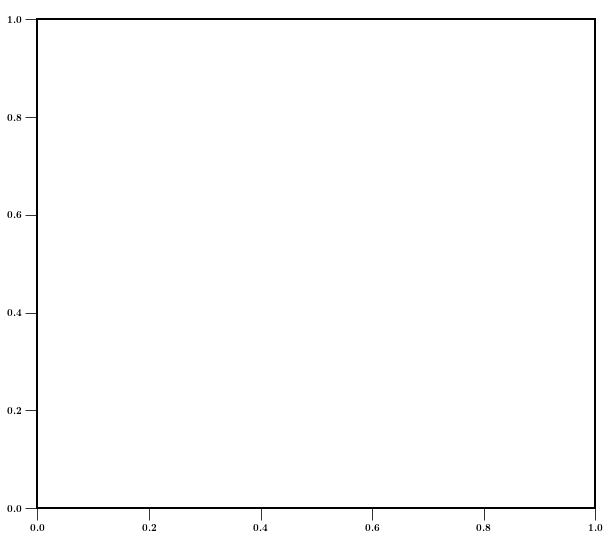

In [12]:
fig , ax0       = plt.subplots(1,1,figsize=(10,9))

############
#  Top panel with MSSFR
############

M1         = Data.COMPAS.mass1
M2         = Data.COMPAS.mass2
MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)
var_x = MBH / MNS

print MNS

bins       = np.linspace(1,13.5,100)
center     = (bins[1:]+bins[:-1])/2.
dvar_x      = np.diff(bins)

for nrL, L in enumerate(labels):
    rate       = rates[nrL]
    rate, _    = np.histogram(var_x, bins=bins, weights = rate)
    rate       = np.divide(rate, dvar_x)
    rate       = rate / np.sum(rate)
    label      = labels[nrL]+r' $\rm \normalfont [%s \ yr^{-1}]$' %(int(totals[nrL]))
    ax0.plot(center, rate, lw=3.5, c=colours[nrL], label=label, linestyle=linestyles[nrL], alpha=0.85)
# ax0.get_xaxis().set_visible(True)
nameX = r'$\rm q = M_{BH} / M_{NS} $'
nameY = r'$\rm p(q)   $'
ax0 = CV.layoutAxes(ax0, nameX=nameX, nameY=nameY)
ax0.legend(loc=1, prop={'size':16})
topp = 0.06
ax0.set_ylim(bottom=0, top=topp)
ax0.set_xlim(left=0)

## FILL PLOT WHERE BH-NS produces EM counterpart
xx = [0,3.5]  #np.linspace(min(bins),max(bins),2)
yy_disrupt_0spin = [0, topp]   
xx_BHspin_0_5 = [0,7.1] 
labelqlegend=r'$M_{\rm{ej}} > 0  \ (\chi_{BH}=0$ )'
labelqlegend2=r'$M_{\rm{ej}} > 0 \ (\chi_{BH}=0.5$)'

Mejected = ax0.fill_between(x=xx,y1=[yy_disrupt_0spin[0],yy_disrupt_0spin[0]], \
                       y2=[yy_disrupt_0spin[1],yy_disrupt_0spin[1]],\
                        color='gray', label=labelqlegend, alpha =0.6,hatch='/')
ax0.plot([3.5,3.5], yy_disrupt_0spin, lw=2, color='k', linestyle=':' )



Mejected2 = ax0.fill_between(x=xx_BHspin_0_5,y1=[yy_disrupt_0spin[0],yy_disrupt_0spin[0]], \
                       y2=[yy_disrupt_0spin[1],yy_disrupt_0spin[1]],\
                        color='gray', label=labelqlegend, alpha =0.3,hatch='.')
ax0.plot([7.1,7.1], yy_disrupt_0spin, lw=2, color='k', linestyle=':' )


leg2 = Legend(ax0, [Mejected, Mejected2], [labelqlegend, labelqlegend2], fontsize=fs-8, loc="center right")
ax0.add_artist(leg2)

plt.tight_layout()
plt.grid()



# plt.subplots_adjust(wspace=0., hspace=0.0)
plt.savefig('./qDistributionAtRedshiftObs_weighted.png', dpi=300, transparent=False)
plt.show()
# plt.close()

In [ ]:
print var_x

In [ ]:
from matplotlib.legend import Legend

modelname = 'alpha0_1'

# Different model

In [13]:
#path to the data
pathCOMPASOutput = '/Volumes/Virgo/DATA/BHNS/alpha0_1/'
modelname = 'alpha0_1'
#Will only look at BBHs so might as well set everything
minz = 0.
maxz = 1.
resz = 50
Data_model2 = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes='BHNS',\
       minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=False, Cosmology='Custom Flat')

#I use the custom cosmology because this was the flatlambda prescription used before WMAP Stevenson et al 2019
#Doesnt matter to much (between WMAP and 
#this it is 22, and 22.7 per year) but to prevent redoing all the numbers in the tex for referee

print(Data_model2.COMPAS.mass1)
print(len(Data_model2.COMPAS.mass1))

weighted samples :-D
Remember to  self.setCOMPASDCOmask() adag and self.setCOMPASData()
[2.04871 1.35708 1.31002 ... 6.16676 4.9449  6.16654]
50208


In [14]:
rates_model2    = []
totals_model2   = []
for nrL, L in enumerate(labels):
    Data_model2.MSSFR.Zprescription         = method[nrL]
    Data_model2.MSSFR.SFRprescription       = SFRs[nrL]
    Data_model2.MSSFR.logNormalPrescription = logNormal[nrL]
    Data_model2.MSSFR.GSMFprescription      = GSMFs[nrL]
    Data_model2.MSSFR.ZMprescription        = MZs[nrL]
    Data_model2.cosmologicalIntegration()
        
    weightSTROOPWAFEL = Data_model2.COMPAS.weight # //floor weight
    Row        =  np.sum(Data_model2.PerSystemPerRedshift_ratesObserved*weightSTROOPWAFEL, axis=0) # //floor weight

    
#     Row        =np.sum(Data_model2.PerSystemPerRedshift_ratesObserved, axis=0)
    rates_model2.append(Row)
    totals_model2.extend([np.sum(Row)])
    print(L, np.sum(Row))

('Preferred model', 0.05899119823273778)
('Barrett et al. (2018) MSSFR', 0.28010391578239163)
('Furlong et al. (2015) Single', 0.25083697054398735)
('Ma et al. (2015)', 0.10142733520243355)


In [ ]:
fig , ax0       = plt.subplots(1,1,figsize=(10,9))

############
#  Top panel with MSSFR
############

M1         = Data_model2.COMPAS.mass1
M2         = Data_model2.COMPAS.mass2
MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)
var_x = MBH / MNS

print MNS

bins       = np.linspace(1,13.5,100)
center     = (bins[1:]+bins[:-1])/2.
dvar_x      = np.diff(bins)

for nrL, L in enumerate(labels):
    rate       = rates_model2[nrL]
    rate, _    = np.histogram(var_x, bins=bins, weights = rate)
    rate       = np.divide(rate, dvar_x)
    rate       = rate / np.sum(rate)
    label      = labels[nrL]+r' $\rm \normalfont [%s \ yr^{-1}]$' %(int(totals_model2[nrL]))
    ax0.plot(center, rate, lw=3.5, c=colours[nrL], label=label, linestyle=linestyles[nrL], alpha=0.85)
# ax0.get_xaxis().set_visible(True)
nameX = r'$\rm q = M_{BH} / M_{NS} $'
nameY = r'$\rm p(q)   $'
ax0 = CV.layoutAxes(ax0, nameX=nameX, nameY=nameY)
ax0.legend(loc=1, prop={'size':16})
topp = 0.06
ax0.set_ylim(bottom=0, top=topp)
ax0.set_xlim(left=0)

## FILL PLOT WHERE BH-NS produces EM counterpart
xx = [0,3.5]  #np.linspace(min(bins),max(bins),2)
yy_disrupt_0spin = [0, topp]   
xx_BHspin_0_5 = [0,7.1] 
labelqlegend=r'$M_{\rm{ej}} > 0  \ (\chi_{BH}=0$ )'
labelqlegend2=r'$M_{\rm{ej}} > 0 \ (\chi_{BH}=0.5$)'

Mejected = ax0.fill_between(x=xx,y1=[yy_disrupt_0spin[0],yy_disrupt_0spin[0]], \
                       y2=[yy_disrupt_0spin[1],yy_disrupt_0spin[1]],\
                        color='gray', label=labelqlegend, alpha =0.6,hatch='/')
ax0.plot([3.5,3.5], yy_disrupt_0spin, lw=2, color='k', linestyle=':' )



Mejected2 = ax0.fill_between(x=xx_BHspin_0_5,y1=[yy_disrupt_0spin[0],yy_disrupt_0spin[0]], \
                       y2=[yy_disrupt_0spin[1],yy_disrupt_0spin[1]],\
                        color='gray', label=labelqlegend, alpha =0.3,hatch='.')
ax0.plot([7.1,7.1], yy_disrupt_0spin, lw=2, color='k', linestyle=':' )


leg2 = Legend(ax0, [Mejected, Mejected2], [labelqlegend, labelqlegend2], fontsize=fs-8, loc="center right")
ax0.add_artist(leg2)

plt.tight_layout()
plt.grid()



# plt.subplots_adjust(wspace=0., hspace=0.0)
plt.savefig('./qDistributionAtRedshiftObs'+'_model_'+ modelname + '.png', dpi=300, transparent=False)
plt.show()
# plt.close()




# MODEL 2: ALPHA = 10 

In [15]:
#path to the data
pathCOMPASOutput = '/Volumes/Virgo/DATA/BHNS/alpha_10/'
modelname = 'alpha_10'
#Will only look at BBHs so might as well set everything
minz = 0.
maxz = 1.
resz = 50
Data_model3 = CI.CosmicIntegrator(COMPASpath = pathCOMPASOutput, DCOtypes='BHNS',\
       minRedshift=minz,   maxRedshift=maxz, nrRedshiftBins=resz, optimistic=False, Cosmology='Custom Flat')

#I use the custom cosmology because this was the flatlambda prescription used before WMAP Stevenson et al 2019
#Doesnt matter to much (between WMAP and 
#this it is 22, and 22.7 per year) but to prevent redoing all the numbers in the tex for referee

print(Data_model3.COMPAS.mass1)
print(len(Data_model3.COMPAS.mass1))

weighted samples :-D
Remember to  self.setCOMPASDCOmask() adag and self.setCOMPASData()
[3.40435 4.77606 1.27758 ... 6.16676 4.9449  6.16654]
275375


In [16]:
rates_model3    = []
totals_model3   = []
for nrL, L in enumerate(labels):
    Data_model3.MSSFR.Zprescription         = method[nrL]
    Data_model3.MSSFR.SFRprescription       = SFRs[nrL]
    Data_model3.MSSFR.logNormalPrescription = logNormal[nrL]
    Data_model3.MSSFR.GSMFprescription      = GSMFs[nrL]
    Data_model3.MSSFR.ZMprescription        = MZs[nrL]
    Data_model3.cosmologicalIntegration()
        
    weightSTROOPWAFEL = Data_model3.COMPAS.weight # //floor weight
    Row        =  np.sum(Data_model3.PerSystemPerRedshift_ratesObserved*weightSTROOPWAFEL, axis=0) # //floor weight

    
#     Row        =np.sum(Data_model3.PerSystemPerRedshift_ratesObserved, axis=0)
    rates_model3.append(Row)
    totals_model3.extend([np.sum(Row)])
    print(L, np.sum(Row))

('Preferred model', 0.10199714353828129)
('Barrett et al. (2018) MSSFR', 0.772984147608102)
('Furlong et al. (2015) Single', 1.0179612776306053)
('Ma et al. (2015)', 0.1278321974599789)


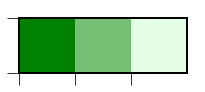

In [99]:
snscolor = sns.palplot(sns.light_palette("green",3, reverse=True))
snscolor = sns.color_palette(sns.light_palette("green",3 , reverse=True))

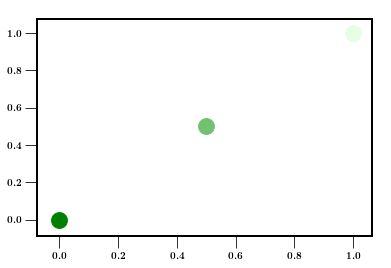

In [100]:
for xx_ind, xx in enumerate(np.linspace(0,1,3)):
    plt.scatter(xx,xx, c=snscolor[xx_ind], s=250)
    
    
    

In [103]:
xx = np.linspace(0,1,8)
print(xx[4:7])
print(xx[2])

[0.57142857 0.71428571 0.85714286]
0.2857142857142857


# PLOT COMBINED 

In [17]:
from matplotlib.legend import Legend

modelname = 'alpha0_1'

import seaborn as sns;

sns.color_palette("husl", 8)
# ...    _ = plt.plot(np.c_[np.zeros(8), np.arange(8)].T)

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.8087954113106306, 0.5634700050056693, 0.19502642696727285),
 (0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 (0.19783576093349015, 0.6955516966063037, 0.3995301037444499),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.22335772267769388, 0.6565792317435265, 0.8171355503265633),
 (0.6423044349219739, 0.5497680051256467, 0.9582651433656727),
 (0.9603888539940703, 0.3814317878772117, 0.8683117650835491)]

[2.06203 2.17938 1.96106 ... 1.27758 1.27758 1.27758]
[2.04871 1.35708 1.31002 ... 1.29909 1.67342 1.81178]
[1.98766 1.66562 1.27758 ... 1.29909 1.67342 1.81178]


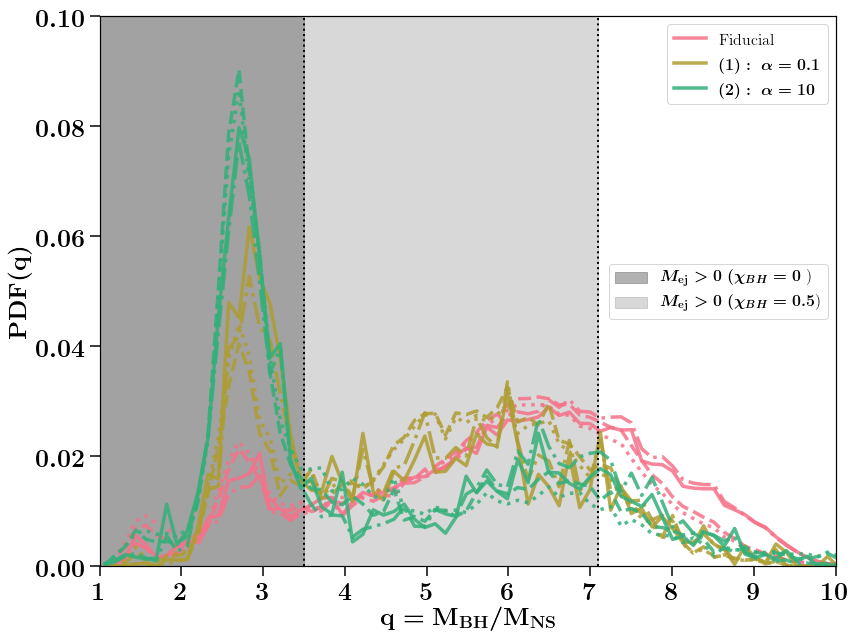

In [21]:


def plot_q_distributions(modelnameslist, rateslist, totalslist, Datalist):
    fig , ax0       = plt.subplots(1,1,figsize=(12,9))

            ############
            #  Top panel with MSSFR
            ############
    for ind_m, model in enumerate(modelnameslist):
        Data = Datalist[ind_m]
        rates = rateslist[ind_m]
        totals = totalslist[ind_m]


        M1         = Data.COMPAS.mass1
        M2         = Data.COMPAS.mass2
        MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)
        var_x = MBH / MNS
        weights = Data.COMPAS.weight

        print MNS

        bins       = np.linspace(1,13.5,100)
        center     = (bins[1:]+bins[:-1])/2.
        dvar_x      = np.diff(bins)

        for nrL, L in enumerate(labels):
            rate       = rates[nrL]
            rate, _    = np.histogram(var_x, bins=bins, weights = rate)
            rate       = np.divide(rate, dvar_x)
            rate       = rate / np.sum(rate)
#             label      = labels[nrL]+r' $\rm \normalfont [%s \ yr^{-1}]$' %(int(totals[nrL]))
#             ax0.plot(center, rate, lw=3.5, c=colours[nrL], label=label, linestyle=linestyles[nrL], alpha=0.85)
            if nrL==0:
                label = modelnameslist[ind_m]
            else:
                label = None
            ax0.plot(center, rate, lw=3.5, c=modelcolors[ind_m], label=label, linestyle=linestyles[nrL], alpha=0.85)



    
    # ax0.get_xaxis().set_visible(True)
    nameX = r'$\rm q = M_{BH} / M_{NS} $'
    nameY = r'$\rm PDF(q)   $'
    ax0 = CV.layoutAxes(ax0, nameX=nameX, nameY=nameY)
    ax0.legend(loc=1, prop={'size':16})
    topp = 0.1
    ax0.set_ylim(bottom=0, top=topp)
    ax0.set_xlim(left=1, right=10)

    ## FILL PLOT WHERE BH-NS produces EM counterpart
    xx = [0,3.5]  #np.linspace(min(bins),max(bins),2)
    yy_disrupt_0spin = [0, topp]   
    xx_BHspin_0_5 = [0,7.1] 
    labelqlegend=r'$M_{\rm{ej}} > 0  \ (\chi_{BH}=0$ )'
    labelqlegend2=r'$M_{\rm{ej}} > 0 \ (\chi_{BH}=0.5$)'

    Mejected = ax0.fill_between(x=xx,y1=[yy_disrupt_0spin[0],yy_disrupt_0spin[0]], \
                           y2=[yy_disrupt_0spin[1],yy_disrupt_0spin[1]],\
                            color='gray', label=labelqlegend, alpha =0.6)
    ax0.plot([3.5,3.5], yy_disrupt_0spin, lw=2, color='k', linestyle=':' )



    Mejected2 = ax0.fill_between(x=xx_BHspin_0_5,y1=[yy_disrupt_0spin[0],yy_disrupt_0spin[0]], \
                           y2=[yy_disrupt_0spin[1],yy_disrupt_0spin[1]],\
                            color='gray', label=labelqlegend, alpha =0.3)
    ax0.plot([7.1,7.1], yy_disrupt_0spin, lw=2, color='k', linestyle=':' )


    leg2 = Legend(ax0, [Mejected, Mejected2], [labelqlegend, labelqlegend2], fontsize=fs-8, loc="center right")
    ax0.add_artist(leg2)

    plt.tight_layout()
#     plt.grid()



    # plt.subplots_adjust(wspace=0., hspace=0.0)
    plt.savefig('./qDistributionAtRedshiftObs'+ 'combinedmodels'  + '.png', dpi=300, transparent=False)
    plt.show()
    # plt.close()

cm       = plt.get_cmap('plasma_r')
modelcolors = sns.color_palette("husl", 5) 

Datalist = [Data_model1, Data_model2, Data_model3]
modelnameslist = [r'Fiducial', r'$(1): \ \alpha=0.1$', r'$(2): \ \alpha=10$']
rateslist = [rates_model1, rates_model2, rates_model3]
totalslist = [totals_model1, totals_model2, totals_model3]

plot_q_distributions(modelnameslist, rateslist, totalslist, Datalist)

In [50]:
# TOTAL MASS 

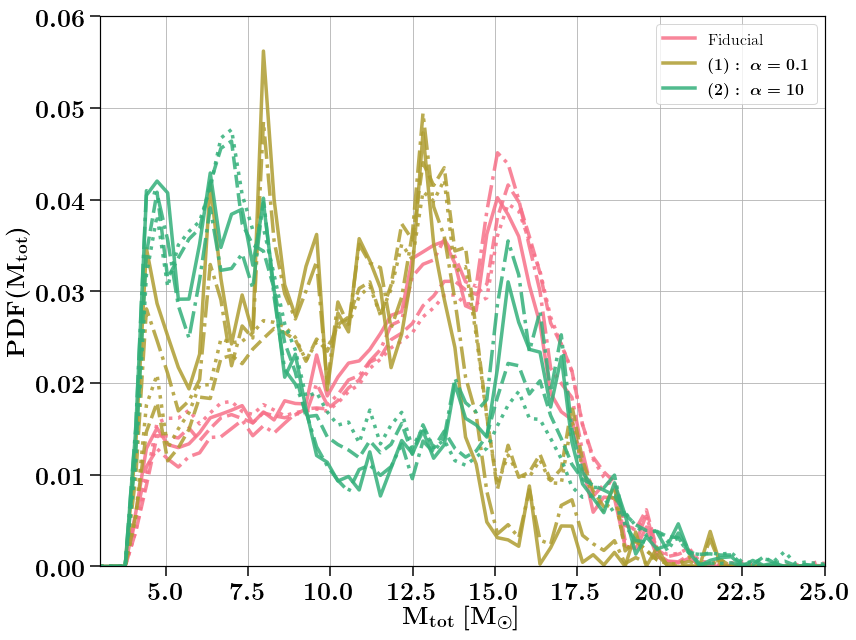

In [25]:


def plot_mtot_distributions(modelnameslist, rateslist, totalslist, Datalist):
    fig , ax0       = plt.subplots(1,1,figsize=(12,9))

            ############
            #  Top panel with MSSFR
            ############
    for ind_m, model in enumerate(modelnameslist):
        Data = Datalist[ind_m]
        rates = rateslist[ind_m]
        totals = totalslist[ind_m]


        M1         = Data.COMPAS.mass1
        M2         = Data.COMPAS.mass2
#         MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)
        var_x = M1 + M2

#         print MNS

        bins       = np.linspace(2,27.5,80)
        center     = (bins[1:]+bins[:-1])/2.
        dvar_x      = np.diff(bins)

        for nrL, L in enumerate(labels):
            rate       = rates[nrL]
            rate, _    = np.histogram(var_x, bins=bins, weights = rate)
            rate       = np.divide(rate, dvar_x)
            rate       = rate / np.sum(rate)
#             label      = labels[nrL]+r' $\rm \normalfont [%s \ yr^{-1}]$' %(int(totals[nrL]))
#             ax0.plot(center, rate, lw=3.5, c=colours[nrL], label=label, linestyle=linestyles[nrL], alpha=0.85)
            if nrL==0:
                label = modelnameslist[ind_m]
            else:
                label = None
            ax0.plot(center, rate, lw=3.5, c=modelcolors[ind_m], label=label, linestyle=linestyles[nrL], alpha=0.85)



    
    # ax0.get_xaxis().set_visible(True)
    nameX = r'$\rm M_{\rm{tot}} \ [{\rm{M}}_{\odot}]$'
    nameY = r'$\rm PDF(M_{\rm{tot}})   $'
    ax0 = CV.layoutAxes(ax0, nameX=nameX, nameY=nameY)
    ax0.legend(loc=1, prop={'size':16})
    topp = 0.06
    ax0.set_ylim(bottom=0, top=topp)
    ax0.set_xlim(left=3, right=25)

    ## FILL PLOT WHERE BH-NS produces EM counterpart
#     xx = [0,3.5]  #np.linspace(min(bins),max(bins),2)
#     yy_disrupt_0spin = [0, topp]   
#     xx_BHspin_0_5 = [0,7.1] 
#     labelqlegend=r'$M_{\rm{ej}} > 0  \ (\chi_{BH}=0$ )'
#     labelqlegend2=r'$M_{\rm{ej}} > 0 \ (\chi_{BH}=0.5$)'

#     Mejected = ax0.fill_between(x=xx,y1=[yy_disrupt_0spin[0],yy_disrupt_0spin[0]], \
#                            y2=[yy_disrupt_0spin[1],yy_disrupt_0spin[1]],\
#                             color='gray', label=labelqlegend, alpha =0.6)
#     ax0.plot([3.5,3.5], yy_disrupt_0spin, lw=2, color='k', linestyle=':' )



#     Mejected2 = ax0.fill_between(x=xx_BHspin_0_5,y1=[yy_disrupt_0spin[0],yy_disrupt_0spin[0]], \
#                            y2=[yy_disrupt_0spin[1],yy_disrupt_0spin[1]],\
#                             color='gray', label=labelqlegend, alpha =0.3)
#     ax0.plot([7.1,7.1], yy_disrupt_0spin, lw=2, color='k', linestyle=':' )


#     leg2 = Legend(ax0, [Mejected, Mejected2], [labelqlegend, labelqlegend2], fontsize=fs-8, loc="center right")
#     ax0.add_artist(leg2)

    plt.tight_layout()
    plt.grid()



    # plt.subplots_adjust(wspace=0., hspace=0.0)
    plt.savefig('./mtotDistributionAtRedshiftObs'+ 'combinedmodels' + '.png', dpi=300, transparent=False)
    plt.show()
    # plt.close()

cm       = plt.get_cmap('plasma_r')
modelcolors = sns.color_palette("husl", 5) 

Datalist = [Data_model1, Data_model2, Data_model3]
modelnameslist = [r'Fiducial', r'$(1): \ \alpha=0.1$', r'$(2): \ \alpha=10$']
rateslist = [rates_model1, rates_model2, rates_model3]
totalslist = [totals_model1, totals_model2, totals_model3]

plot_mtot_distributions(modelnameslist, rateslist, totalslist, Datalist)

In [ ]:
# Plot individual masses

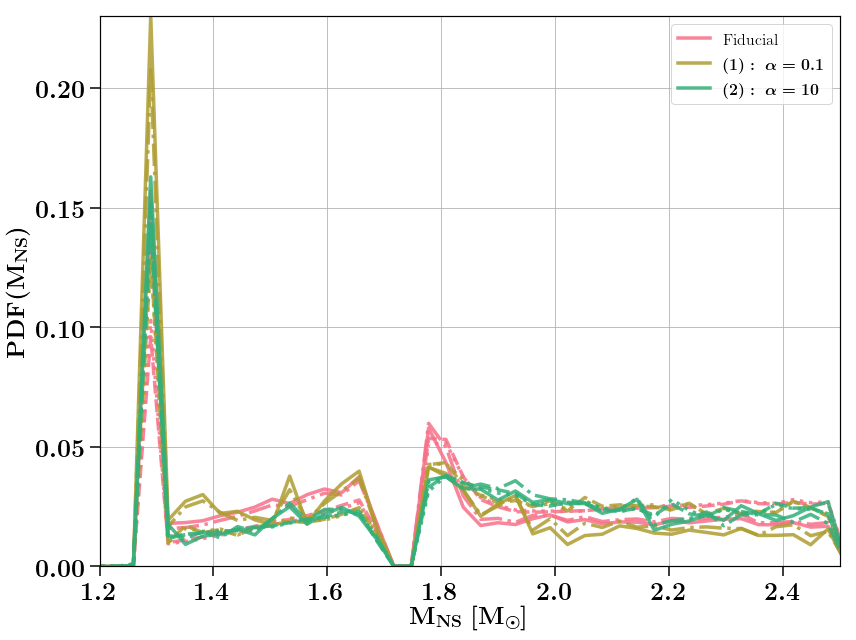

In [30]:


def plot_mns_distributions(modelnameslist, rateslist, totalslist, Datalist):
    fig , ax0       = plt.subplots(1,1,figsize=(12,9))

            ############
            #  Top panel with MSSFR
            ############
    for ind_m, model in enumerate(modelnameslist):
        Data = Datalist[ind_m]
        rates = rateslist[ind_m]
        totals = totalslist[ind_m]


        M1         = Data.COMPAS.mass1
        M2         = Data.COMPAS.mass2
        MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)
        var_x = MNS

#         print MNS

        bins       = np.linspace(1,2.8,60)
        center     = (bins[1:]+bins[:-1])/2.
        dvar_x      = np.diff(bins)

        for nrL, L in enumerate(labels):
            rate       = rates[nrL]
            rate, _    = np.histogram(var_x, bins=bins, weights = rate)
            rate       = np.divide(rate, dvar_x)
            rate       = rate / np.sum(rate)
#             label      = labels[nrL]+r' $\rm \normalfont [%s \ yr^{-1}]$' %(int(totals[nrL]))
#             ax0.plot(center, rate, lw=3.5, c=colours[nrL], label=label, linestyle=linestyles[nrL], alpha=0.85)
            if nrL==0:
                label = modelnameslist[ind_m]
            else:
                label = None
            ax0.plot(center, rate, lw=3.5, c=modelcolors[ind_m], label=label, linestyle=linestyles[nrL], alpha=0.85)



    
    # ax0.get_xaxis().set_visible(True)
    nameX = r'$\rm M_{\rm{NS}} \ [{\rm{M}}_{\odot}]$'
    nameY = r'$\rm PDF(M_{\rm{NS}})   $'
    ax0 = CV.layoutAxes(ax0, nameX=nameX, nameY=nameY)
    ax0.legend(loc=1, prop={'size':16})
    topp = 0.23
    ax0.set_ylim(bottom=0, top=topp)
    ax0.set_xlim(left=1.2, right=2.5)

    ## FILL PLOT WHERE BH-NS produces EM counterpart
#     xx = [0,3.5]  #np.linspace(min(bins),max(bins),2)
#     yy_disrupt_0spin = [0, topp]   
#     xx_BHspin_0_5 = [0,7.1] 
#     labelqlegend=r'$M_{\rm{ej}} > 0  \ (\chi_{BH}=0$ )'
#     labelqlegend2=r'$M_{\rm{ej}} > 0 \ (\chi_{BH}=0.5$)'

#     Mejected = ax0.fill_between(x=xx,y1=[yy_disrupt_0spin[0],yy_disrupt_0spin[0]], \
#                            y2=[yy_disrupt_0spin[1],yy_disrupt_0spin[1]],\
#                             color='gray', label=labelqlegend, alpha =0.6)
#     ax0.plot([3.5,3.5], yy_disrupt_0spin, lw=2, color='k', linestyle=':' )



#     Mejected2 = ax0.fill_between(x=xx_BHspin_0_5,y1=[yy_disrupt_0spin[0],yy_disrupt_0spin[0]], \
#                            y2=[yy_disrupt_0spin[1],yy_disrupt_0spin[1]],\
#                             color='gray', label=labelqlegend, alpha =0.3)
#     ax0.plot([7.1,7.1], yy_disrupt_0spin, lw=2, color='k', linestyle=':' )


#     leg2 = Legend(ax0, [Mejected, Mejected2], [labelqlegend, labelqlegend2], fontsize=fs-8, loc="center right")
#     ax0.add_artist(leg2)

    plt.tight_layout()
    plt.grid()



    # plt.subplots_adjust(wspace=0., hspace=0.0)
    plt.savefig('./mnsDistributionAtRedshiftObs'+ 'combinedmodels' + '.png', dpi=300, transparent=False)
    plt.show()
    # plt.close()

cm       = plt.get_cmap('plasma_r')
modelcolors = sns.color_palette("husl", 5) 

Datalist = [Data_model1, Data_model2, Data_model3]
modelnameslist = [r'Fiducial', r'$(1): \ \alpha=0.1$', r'$(2): \ \alpha=10$']
rateslist = [rates_model1, rates_model2, rates_model3]
totalslist = [totals_model1, totals_model2, totals_model3]

plot_mns_distributions(modelnameslist, rateslist, totalslist, Datalist)

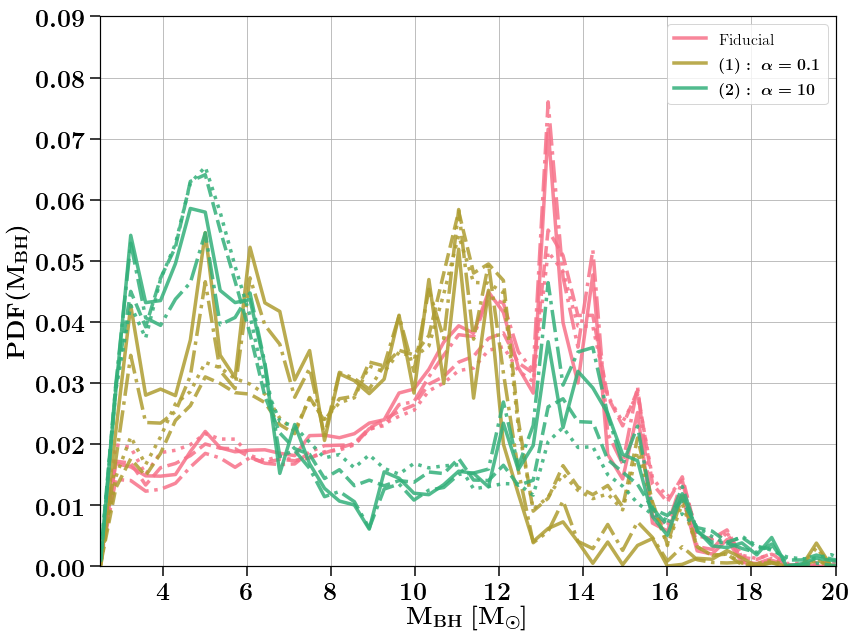

In [32]:


def plot_mbh_distributions(modelnameslist, rateslist, totalslist, Datalist):
    fig , ax0       = plt.subplots(1,1,figsize=(12,9))

            ############
            #  Top panel with MSSFR
            ############
    for ind_m, model in enumerate(modelnameslist):
        Data = Datalist[ind_m]
        rates = rateslist[ind_m]
        totals = totalslist[ind_m]


        M1         = Data.COMPAS.mass1
        M2         = Data.COMPAS.mass2
        MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)
        var_x = MBH

#         print MNS

        bins       = np.linspace(2,30,80)
        center     = (bins[1:]+bins[:-1])/2.
        dvar_x      = np.diff(bins)

        for nrL, L in enumerate(labels):
            rate       = rates[nrL]
            rate, _    = np.histogram(var_x, bins=bins, weights = rate)
            rate       = np.divide(rate, dvar_x)
            rate       = rate / np.sum(rate)
#             label      = labels[nrL]+r' $\rm \normalfont [%s \ yr^{-1}]$' %(int(totals[nrL]))
#             ax0.plot(center, rate, lw=3.5, c=colours[nrL], label=label, linestyle=linestyles[nrL], alpha=0.85)
            if nrL==0:
                label = modelnameslist[ind_m]
            else:
                label = None
            ax0.plot(center, rate, lw=3.5, c=modelcolors[ind_m], label=label, linestyle=linestyles[nrL], alpha=0.85)



    
    # ax0.get_xaxis().set_visible(True)
    nameX = r'$\rm M_{\rm{BH}} \ [{\rm{M}}_{\odot}]$'
    nameY = r'$\rm PDF(M_{\rm{BH}})   $'
    ax0 = CV.layoutAxes(ax0, nameX=nameX, nameY=nameY)
    ax0.legend(loc=1, prop={'size':16})
    topp = 0.09
    ax0.set_ylim(bottom=0, top=topp)
    ax0.set_xlim(left=2.5, right=20.0)

    ## FILL PLOT WHERE BH-NS produces EM counterpart
#     xx = [0,3.5]  #np.linspace(min(bins),max(bins),2)
#     yy_disrupt_0spin = [0, topp]   
#     xx_BHspin_0_5 = [0,7.1] 
#     labelqlegend=r'$M_{\rm{ej}} > 0  \ (\chi_{BH}=0$ )'
#     labelqlegend2=r'$M_{\rm{ej}} > 0 \ (\chi_{BH}=0.5$)'

#     Mejected = ax0.fill_between(x=xx,y1=[yy_disrupt_0spin[0],yy_disrupt_0spin[0]], \
#                            y2=[yy_disrupt_0spin[1],yy_disrupt_0spin[1]],\
#                             color='gray', label=labelqlegend, alpha =0.6)
#     ax0.plot([3.5,3.5], yy_disrupt_0spin, lw=2, color='k', linestyle=':' )



#     Mejected2 = ax0.fill_between(x=xx_BHspin_0_5,y1=[yy_disrupt_0spin[0],yy_disrupt_0spin[0]], \
#                            y2=[yy_disrupt_0spin[1],yy_disrupt_0spin[1]],\
#                             color='gray', label=labelqlegend, alpha =0.3)
#     ax0.plot([7.1,7.1], yy_disrupt_0spin, lw=2, color='k', linestyle=':' )


#     leg2 = Legend(ax0, [Mejected, Mejected2], [labelqlegend, labelqlegend2], fontsize=fs-8, loc="center right")
#     ax0.add_artist(leg2)

    plt.tight_layout()
    plt.grid()



    # plt.subplots_adjust(wspace=0., hspace=0.0)
    plt.savefig('./mbhDistributionAtRedshiftObs'+ 'combinedmodels' + '.png', dpi=300, transparent=False)
    plt.show()
    # plt.close()

cm       = plt.get_cmap('plasma_r')
modelcolors = sns.color_palette("husl", 5) 

Datalist = [Data_model1, Data_model2, Data_model3]
modelnameslist = [r'Fiducial', r'$(1): \ \alpha=0.1$', r'$(2): \ \alpha=10$']
rateslist = [rates_model1, rates_model2, rates_model3]
totalslist = [totals_model1, totals_model2, totals_model3]

plot_mbh_distributions(modelnameslist, rateslist, totalslist, Datalist)

# CHIRP MASS

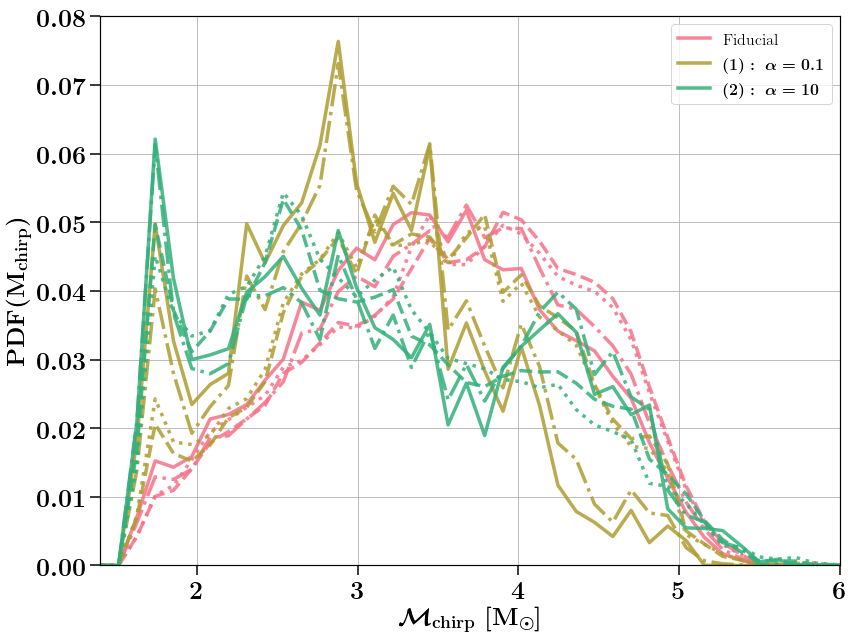

In [34]:


def plot_mchirp_distributions(modelnameslist, rateslist, totalslist, Datalist):
    fig , ax0       = plt.subplots(1,1,figsize=(12,9))

            ############
            #  Top panel with MSSFR
            ############
    for ind_m, model in enumerate(modelnameslist):
        Data = Datalist[ind_m]
        rates = rateslist[ind_m]
        totals = totalslist[ind_m]


        M1         = Data.COMPAS.mass1
        M2         = Data.COMPAS.mass2
        MBH, MNS = obtainM1BHandM2BHassymetric(m1=M1, m2=M2)
        var_x = Data.COMPAS.mChirp

#         print MNS

        bins       = np.linspace(1,10,80)
        center     = (bins[1:]+bins[:-1])/2.
        dvar_x      = np.diff(bins)

        for nrL, L in enumerate(labels):
            rate       = rates[nrL]
            rate, _    = np.histogram(var_x, bins=bins, weights = rate)
            rate       = np.divide(rate, dvar_x)
            rate       = rate / np.sum(rate)
#             label      = labels[nrL]+r' $\rm \normalfont [%s \ yr^{-1}]$' %(int(totals[nrL]))
#             ax0.plot(center, rate, lw=3.5, c=colours[nrL], label=label, linestyle=linestyles[nrL], alpha=0.85)
            if nrL==0:
                label = modelnameslist[ind_m]
            else:
                label = None
            ax0.plot(center, rate, lw=3.5, c=modelcolors[ind_m], label=label, linestyle=linestyles[nrL], alpha=0.85)



    
    # ax0.get_xaxis().set_visible(True)
    nameX = r'$\rm \mathcal{M}_{\rm{chirp}} \ [{\rm{M}}_{\odot}]$'
    nameY = r'$\rm PDF(M_{\rm{chirp}})   $'
    ax0 = CV.layoutAxes(ax0, nameX=nameX, nameY=nameY)
    ax0.legend(loc=1, prop={'size':16})
    topp = 0.08
    ax0.set_ylim(bottom=0, top=topp)
    ax0.set_xlim(left=1.4, right=6)

    ## FILL PLOT WHERE BH-NS produces EM counterpart
#     xx = [0,3.5]  #np.linspace(min(bins),max(bins),2)
#     yy_disrupt_0spin = [0, topp]   
#     xx_BHspin_0_5 = [0,7.1] 
#     labelqlegend=r'$M_{\rm{ej}} > 0  \ (\chi_{BH}=0$ )'
#     labelqlegend2=r'$M_{\rm{ej}} > 0 \ (\chi_{BH}=0.5$)'

#     Mejected = ax0.fill_between(x=xx,y1=[yy_disrupt_0spin[0],yy_disrupt_0spin[0]], \
#                            y2=[yy_disrupt_0spin[1],yy_disrupt_0spin[1]],\
#                             color='gray', label=labelqlegend, alpha =0.6)
#     ax0.plot([3.5,3.5], yy_disrupt_0spin, lw=2, color='k', linestyle=':' )



#     Mejected2 = ax0.fill_between(x=xx_BHspin_0_5,y1=[yy_disrupt_0spin[0],yy_disrupt_0spin[0]], \
#                            y2=[yy_disrupt_0spin[1],yy_disrupt_0spin[1]],\
#                             color='gray', label=labelqlegend, alpha =0.3)
#     ax0.plot([7.1,7.1], yy_disrupt_0spin, lw=2, color='k', linestyle=':' )


#     leg2 = Legend(ax0, [Mejected, Mejected2], [labelqlegend, labelqlegend2], fontsize=fs-8, loc="center right")
#     ax0.add_artist(leg2)

    plt.tight_layout()
    plt.grid()



    # plt.subplots_adjust(wspace=0., hspace=0.0)
    plt.savefig('./mchirpDistributionAtRedshiftObs'+ 'combinedmodels' + '.png', dpi=300, transparent=False)
    plt.show()
    # plt.close()

cm       = plt.get_cmap('plasma_r')
modelcolors = sns.color_palette("husl", 5) 

Datalist = [Data_model1, Data_model2, Data_model3]
modelnameslist = [r'Fiducial', r'$(1): \ \alpha=0.1$', r'$(2): \ \alpha=10$']
rateslist = [rates_model1, rates_model2, rates_model3]
totalslist = [totals_model1, totals_model2, totals_model3]

plot_mchirp_distributions(modelnameslist, rateslist, totalslist, Datalist)

In [ ]:
.tc

-13.961431495543849
-10.142275609031692
-12.651498483084568


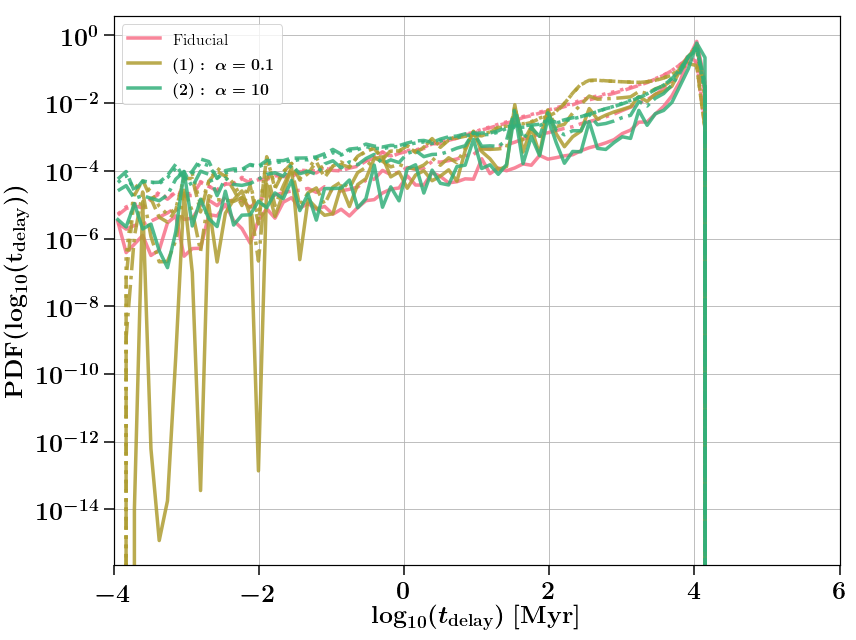

In [36]:


def plot_tdelay_distributions(modelnameslist, rateslist, totalslist, Datalist):
    fig , ax0       = plt.subplots(1,1,figsize=(12,9))

            ############
            #  Top panel with MSSFR
            ############
    for ind_m, model in enumerate(modelnameslist):
        Data = Datalist[ind_m]
        rates = rateslist[ind_m]
        totals = totalslist[ind_m]



        var_x = Data.COMPAS.tc
        var_x = np.log10(var_x)
        
        print(min(var_x))
#         print MNS

        bins       = np.linspace(-4,5,80)
        center     = (bins[1:]+bins[:-1])/2.
        dvar_x      = np.diff(bins)

        for nrL, L in enumerate(labels):
            rate       = rates[nrL]
            rate, _    = np.histogram(var_x, bins=bins, weights = rate)
            rate       = np.divide(rate, dvar_x)
            rate       = rate / np.sum(rate)
#             label      = labels[nrL]+r' $\rm \normalfont [%s \ yr^{-1}]$' %(int(totals[nrL]))
#             ax0.plot(center, rate, lw=3.5, c=colours[nrL], label=label, linestyle=linestyles[nrL], alpha=0.85)
            if nrL==0:
                label = modelnameslist[ind_m]
            else:
                label = None
            ax0.plot(center, rate, lw=3.5, c=modelcolors[ind_m], label=label, linestyle=linestyles[nrL], alpha=0.85)



    
    # ax0.get_xaxis().set_visible(True)
    nameX = r'$\log_{10}(t_{\rm{delay}}) \ [{\rm{Myr}}]$'
    nameY = r'$\rm PDF(\log_{10}(t_{\rm{delay}}))   $'
    ax0 = CV.layoutAxes(ax0, nameX=nameX, nameY=nameY)
    ax0.legend(loc=2, prop={'size':16})
    topp = 0.085
#     ax0.set_ylim(bottom=10, top=topp)
    ax0.set_xlim(left=-4, right=6)
    ax0.set_yscale('log')

    plt.tight_layout()
    plt.grid()



    # plt.subplots_adjust(wspace=0., hspace=0.0)
    plt.savefig('./tdelayDistributionAtRedshiftObs'+ 'combinedmodels' + '.png', dpi=300, transparent=False)
    plt.show()
    # plt.close()

cm       = plt.get_cmap('plasma_r')
modelcolors = sns.color_palette("husl", 5) 

Datalist = [Data_model1, Data_model2, Data_model3]
modelnameslist = [r'Fiducial', r'$(1): \ \alpha=0.1$', r'$(2): \ \alpha=10$']
rateslist = [rates_model1, rates_model2, rates_model3]
totalslist = [totals_model1, totals_model2, totals_model3]

plot_tdelay_distributions(modelnameslist, rateslist, totalslist, Datalist)

-13.961431495543849
-10.142275609031692
-12.651498483084568


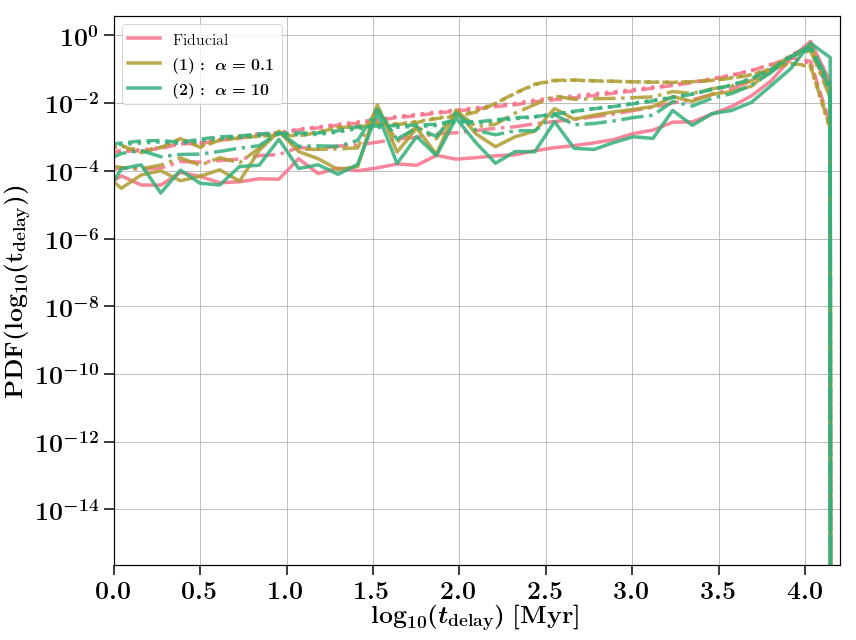

In [44]:


def plot_tdelay_distributions(modelnameslist, rateslist, totalslist, Datalist):
    fig , ax0       = plt.subplots(1,1,figsize=(12,9))

            ############
            #  Top panel with MSSFR
            ############
    for ind_m, model in enumerate(modelnameslist):
        Data = Datalist[ind_m]
        rates = rateslist[ind_m]
        totals = totalslist[ind_m]



        var_x = Data.COMPAS.tc
        var_x = np.log10(var_x)
        
        print(min(var_x))
#         print MNS

        bins       = np.linspace(-4,5,80)
        center     = (bins[1:]+bins[:-1])/2.
        dvar_x      = np.diff(bins)

        for nrL, L in enumerate(labels):
            rate       = rates[nrL]
            rate, _    = np.histogram(var_x, bins=bins, weights = rate)
            rate       = np.divide(rate, dvar_x)
            rate       = rate / np.sum(rate)
#             label      = labels[nrL]+r' $\rm \normalfont [%s \ yr^{-1}]$' %(int(totals[nrL]))
#             ax0.plot(center, rate, lw=3.5, c=colours[nrL], label=label, linestyle=linestyles[nrL], alpha=0.85)
            if nrL==0:
                label = modelnameslist[ind_m]
            else:
                label = None
            ax0.plot(center, rate, lw=3.5, c=modelcolors[ind_m], label=label, linestyle=linestyles[nrL], alpha=0.85)



    
    # ax0.get_xaxis().set_visible(True)
    nameX = r'$\log_{10}(t_{\rm{delay}}) \ [{\rm{Myr}}]$'
    nameY = r'$\rm PDF(\log_{10}(t_{\rm{delay}}))   $'
    ax0 = CV.layoutAxes(ax0, nameX=nameX, nameY=nameY)
    ax0.legend(loc=2, prop={'size':16})
    topp = 0.085
#     ax0.set_ylim(bottom=10, top=topp)
    ax0.set_xlim(left=0, right=4.2)
    ax0.set_yscale('log')

    plt.tight_layout()
    plt.grid()



    # plt.subplots_adjust(wspace=0., hspace=0.0)
    plt.savefig('./tdelayDistributionAtRedshiftObs'+ 'combinedmodels' + 'smallxrange_' '.png', dpi=300, transparent=False)
    plt.show()
    # plt.close()

cm       = plt.get_cmap('plasma_r')
modelcolors = sns.color_palette("husl", 5) 

Datalist = [Data_model1, Data_model2, Data_model3]
modelnameslist = [r'Fiducial', r'$(1): \ \alpha=0.1$', r'$(2): \ \alpha=10$']
rateslist = [rates_model1, rates_model2, rates_model3]
totalslist = [totals_model1, totals_model2, totals_model3]

plot_tdelay_distributions(modelnameslist, rateslist, totalslist, Datalist)

1.09287e-14
7.2065e-11
2.23101e-13


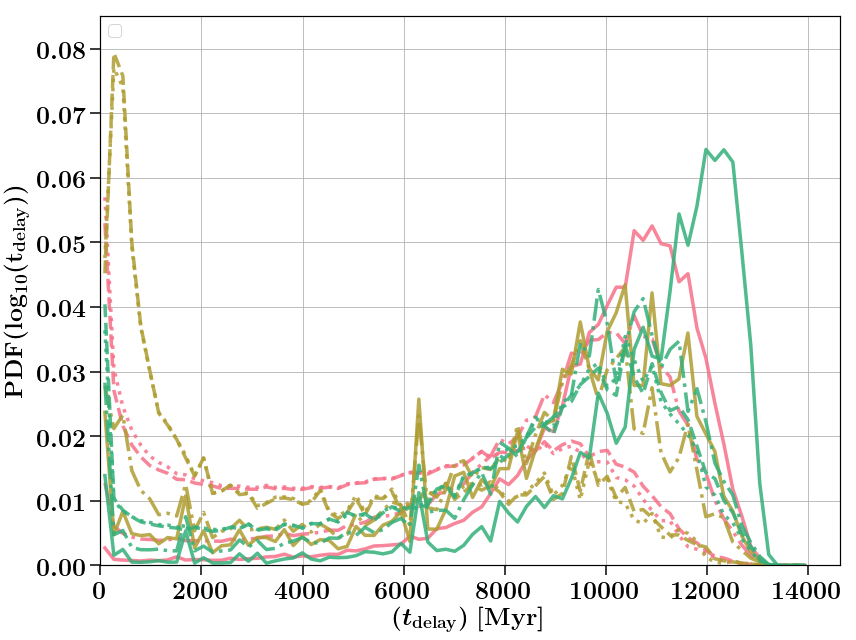

In [42]:


def plot_tdelay_distributions(modelnameslist, rateslist, totalslist, Datalist):
    fig , ax0       = plt.subplots(1,1,figsize=(12,9))

            ############
            #  Top panel with MSSFR
            ############
    for ind_m, model in enumerate(modelnameslist):
        Data = Datalist[ind_m]
        rates = rateslist[ind_m]
        totals = totalslist[ind_m]



        var_x = Data.COMPAS.tc
        var_x = (var_x)
        
        print(min(var_x))
#         print MNS

        bins       = np.linspace(-1,max(var_x),80)
        center     = (bins[1:]+bins[:-1])/2.
        dvar_x      = np.diff(bins)

        for nrL, L in enumerate(labels):
            rate       = rates[nrL]
            rate, _    = np.histogram(var_x, bins=bins, weights = rate)
            rate       = np.divide(rate, dvar_x)
            rate       = rate / np.sum(rate)
#             label      = labels[nrL]+r' $\rm \normalfont [%s \ yr^{-1}]$' %(int(totals[nrL]))
#             ax0.plot(center, rate, lw=3.5, c=colours[nrL], label=label, linestyle=linestyles[nrL], alpha=0.85)
            if nrL==0:
                label = None
            else:
                label = None
            ax0.plot(center, rate, lw=3.5, c=modelcolors[ind_m], label=label, linestyle=linestyles[nrL], alpha=0.85)



    
    # ax0.get_xaxis().set_visible(True)
    nameX = r'$(t_{\rm{delay}}) \ [{\rm{Myr}}]$'
    nameY = r'$\rm PDF(\log_{10}(t_{\rm{delay}}))   $'
    ax0 = CV.layoutAxes(ax0, nameX=nameX, nameY=nameY)
    ax0.legend(loc=2, prop={'size':16})
    topp = 0.085
    ax0.set_ylim(bottom=0, top=topp)
    ax0.set_xlim(left=0)
#     ax0.set_yscale('log')

    plt.tight_layout()
    plt.grid()



    # plt.subplots_adjust(wspace=0., hspace=0.0)
    plt.savefig('./tdelayDistributionAtRedshiftObs'+ 'combinedmodels' + 'LINLIN'+ '.png', dpi=300, transparent=False)
    plt.show()
    # plt.close()

cm       = plt.get_cmap('plasma_r')
modelcolors = sns.color_palette("husl", 5) 

Datalist = [Data_model1, Data_model2, Data_model3]
modelnameslist = [r'Fiducial', r'$(1): \ \alpha=0.1$', r'$(2): \ \alpha=10$']
rateslist = [rates_model1, rates_model2, rates_model3]
totalslist = [totals_model1, totals_model2, totals_model3]

plot_tdelay_distributions(modelnameslist, rateslist, totalslist, Datalist)